In [1]:
import pandas as pd

In [2]:
df_mra = pd.read_csv('/content/drive/MyDrive/food-cost-planner Project/prediction_price/national_MRA_clean.csv')

##Data Preprocessing Class (Preprocessor)

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

class Preprocessor:
    def __init__(self, filepath):
        self.data = pd.read_csv(filepath)

    def remove_outliers(self, column):
        Q1 = self.data[column].quantile(0.25)
        Q3 = self.data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        self.data = self.data[(self.data[column] >= lower_bound) & (self.data[column] <= upper_bound)]
        print(f"Outliers removed from {column}")

    def encode_categorical(self):
        label_encoder = LabelEncoder()
        self.data['product_encoded'] = label_encoder.fit_transform(self.data['product'])
        self.data['category_encoded'] = label_encoder.fit_transform(self.data['category'])
        print("Categorical variables encoded.")

    def convert_to_datetime(self, column):
        self.data[column] = pd.to_datetime(self.data[column])
        print(f"Converted {column} to datetime format.")

    def extract_date_features(self, column):
        self.data['year'] = self.data[column].dt.year
        self.data['month'] = self.data[column].dt.month
        self.data['day'] = self.data[column].dt.day
        print(f"Extracted date features from {column}.")

    def show_insights(self):
        print(self.data.head())
        print("\nData Types:\n", self.data.dtypes)
        print("\nMissing Values:\n", self.data.isnull().sum())

    def get_preprocessed_data(self):
        return self.data



preprocessor = Preprocessor('/content/drive/MyDrive/food-cost-planner Project/prediction_price/national_MRA_clean.csv')  # Replace with your file path

# Remove outliers from a price column
preprocessor.remove_outliers('price')

# Encode categorical variables
preprocessor.encode_categorical()

# Convert 'date' column to datetime
preprocessor.convert_to_datetime('date')
preprocessor.extract_date_features('date')
# Display insights of the preprocessed data
preprocessor.show_insights()

preprocessed_data = preprocessor.get_preprocessed_data()

Outliers removed from price
Categorical variables encoded.
Converted date to datetime format.
Extracted date features from date.
        date location vectorid  price       product  unit_quantity      unit  \
3 1995-01-01   Canada  v735198   7.23   Blade roast            1.0  kilogram   
4 1995-01-01   Canada  v735209   7.12  Stewing beef            1.0  kilogram   
5 1995-01-01   Canada  v735220   3.73   Ground beef            1.0  kilogram   
6 1995-01-01   Canada  v735221   8.36    Pork chops            1.0  kilogram   
7 1995-01-01   Canada  v735222   4.90    Butt roast            1.0  kilogram   

  category  product_encoded  category_encoded  year  month  day  
3  Protein                5                 7  1995      1    1  
4  Protein               42                 7  1995      1    1  
5  Protein               24                 7  1995      1    1  
6  Protein               34                 7  1995      1    1  
7  Protein                7                 7  1995      1  

##Model Training and Testing Class (ModelTrainer)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score


class ModelTrainer:
    def __init__(self, data, features, target):
        self.data = data
        self.features = features
        self.target = target
        self.model = DecisionTreeRegressor()

    def split_data(self):
        train_data = self.data[self.data['date'].dt.year <= 2020]
        test_data = self.data[self.data['date'].dt.year > 2020]
        self.X_train = train_data[self.features]
        self.y_train = train_data[self.target]
        self.X_test = test_data[self.features]
        self.y_test = test_data[self.target]
        print("Data split into training and testing sets.")

    def train_and_evaluate(self):
        self.model.fit(self.X_train, self.y_train)
        predictions = self.model.predict(self.X_test)

        mse = mean_squared_error(self.y_test, predictions)
        rmse = mse ** 0.5
        mae = mean_absolute_error(self.y_test, predictions)
        r2 = r2_score(self.y_test, predictions)

        print(f"Model RMSE: {rmse}")
        print(f"Model MAE: {mae}")
        print(f"Model R-squared: {r2}")


#usage

features = ['year', 'month', 'day', 'product_encoded', 'unit_quantity', 'category_encoded']
target = 'price'
trainer = ModelTrainer(preprocessed_data, features, target)
trainer.split_data()  # Splitting the data
trainer.train_and_evaluate()



Data split into training and testing sets.
Model RMSE: 0.32921161956472844
Model MAE: 0.2170746887966805
Model R-squared: 0.9711869019565571


##Predicting Prices for 2023 (triying to get good results)

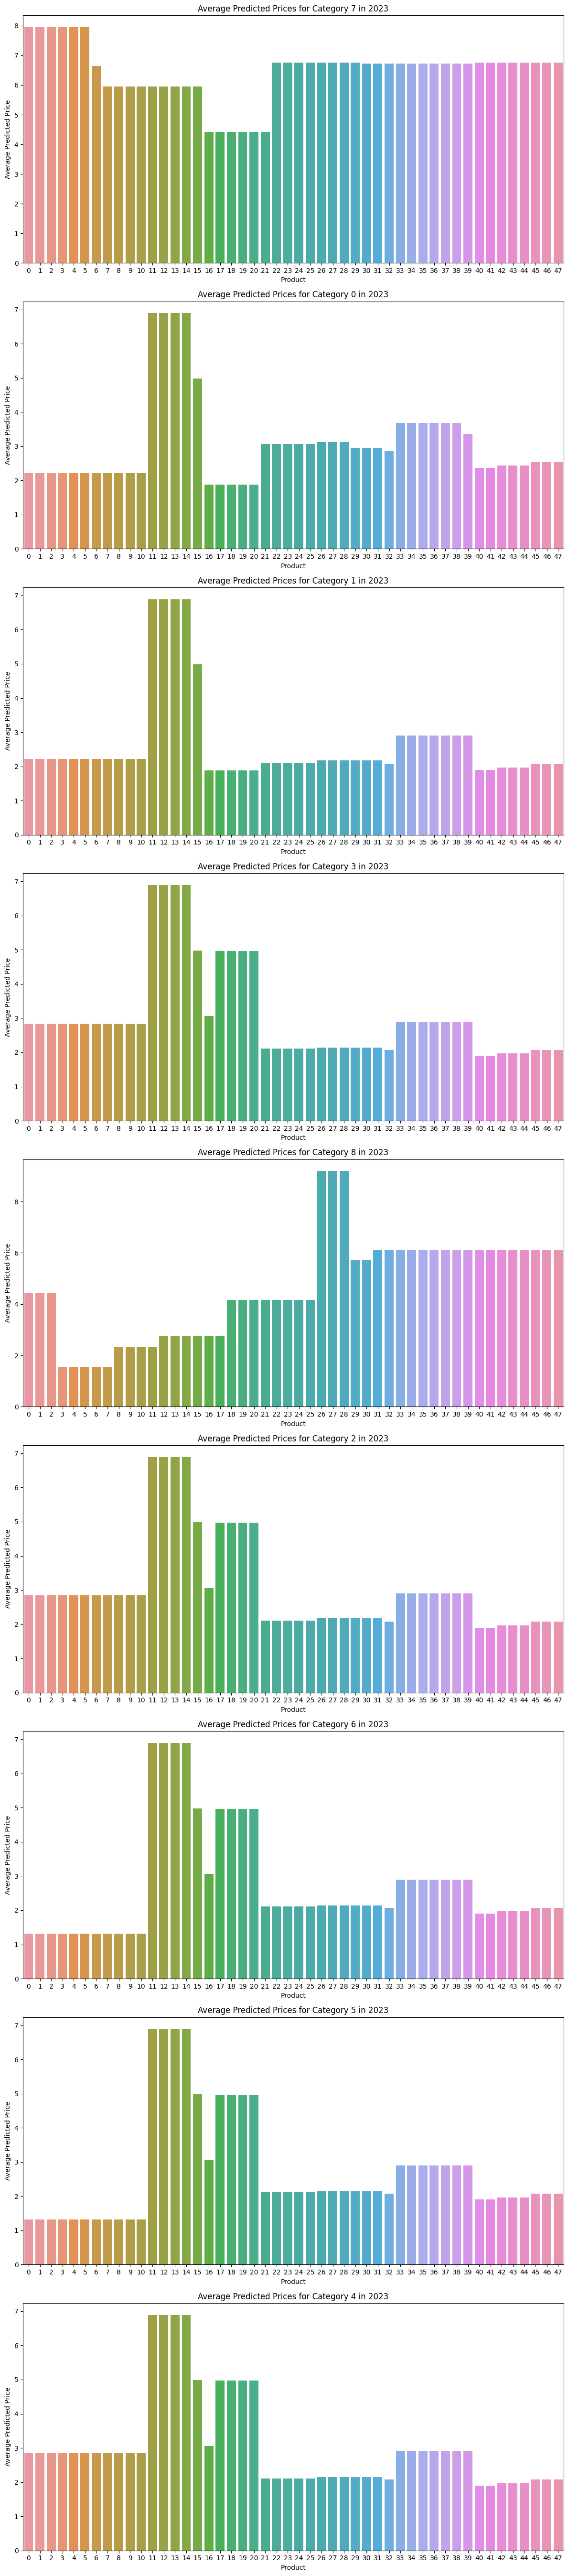

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from datetime import datetime

class ModelPredictor:
    def __init__(self, model, data, features, categories):
        self.model = model
        self.data = data
        self.features = features
        self.categories = categories

    def generate_2023_data(self):
        # Generate feature data for 2023
        df_2023 = pd.DataFrame(product(pd.date_range('2023-01-01', '2023-12-31', freq='D'),
                                       self.data['product_encoded'].unique(),
                                       self.data['unit_quantity'].unique(),
                                       self.data['category_encoded'].unique()),
                               columns=['date', 'product_encoded', 'unit_quantity', 'category_encoded'])

        # Decompose date into year, month, and day
        df_2023['year'] = df_2023['date'].dt.year
        df_2023['month'] = df_2023['date'].dt.month
        df_2023['day'] = df_2023['date'].dt.day

        return df_2023

    def predict_prices(self):
        df_2023 = self.generate_2023_data()
        df_2023 = df_2023[self.features]
        predicted_prices = self.model.predict(df_2023)
        df_2023['predicted_price'] = predicted_prices
        return df_2023

    def plot_predicted_prices(self, predictions):
        # Plotting predicted prices
        average_prices = predictions.groupby(['category_encoded', 'product_encoded'])['predicted_price'].mean().reset_index()
        num_categories = len(self.categories)
        fig, axes = plt.subplots(num_categories, 1, figsize=(12, 6 * num_categories))

        for i, category in enumerate(self.categories):
            category_data = average_prices[average_prices['category_encoded'] == category]
            sns.barplot(ax=axes[i], x='product_encoded', y='predicted_price', data=category_data)
            axes[i].set_title(f'Average Predicted Prices for Category {category} in 2023')
            axes[i].set_ylabel('Average Predicted Price')
            axes[i].set_xlabel('Product')

        plt.tight_layout()
        plt.show()

# Usage
predictor = ModelPredictor(trainer.model, preprocessed_data, features, preprocessed_data['category_encoded'].unique())
predictions_2023 = predictor.predict_prices()
predictor.plot_predicted_prices(predictions_2023)


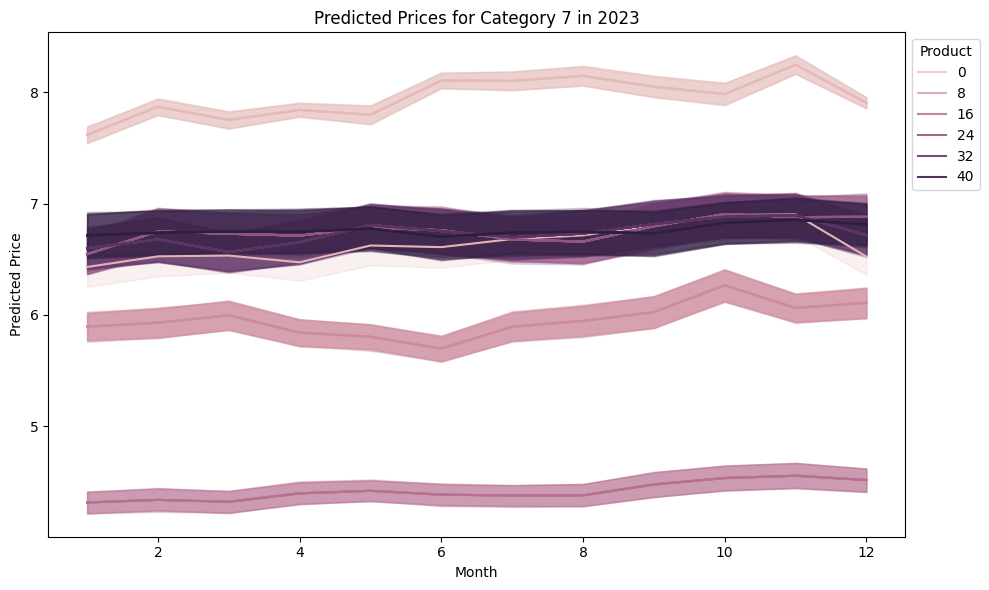

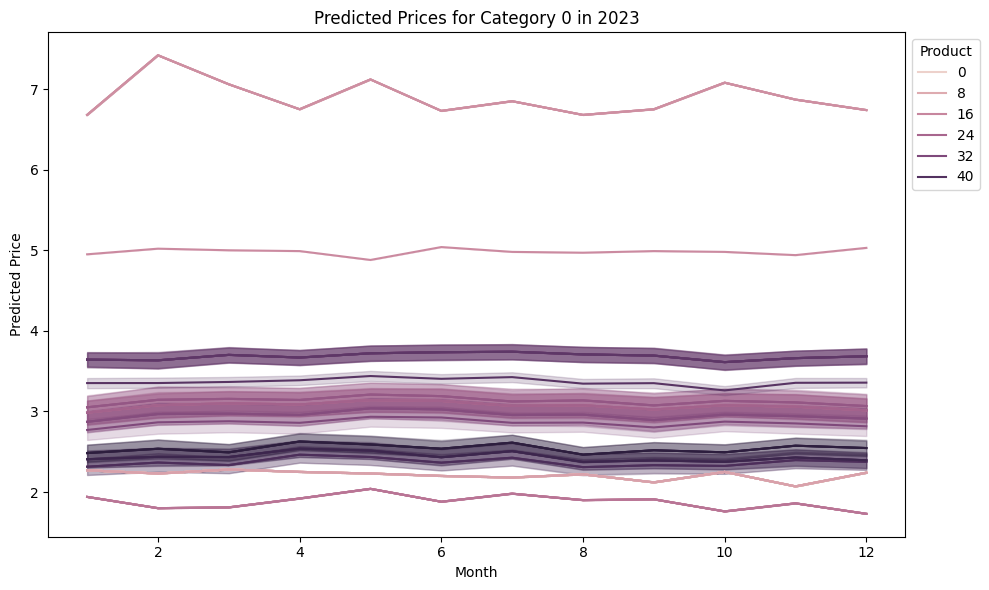

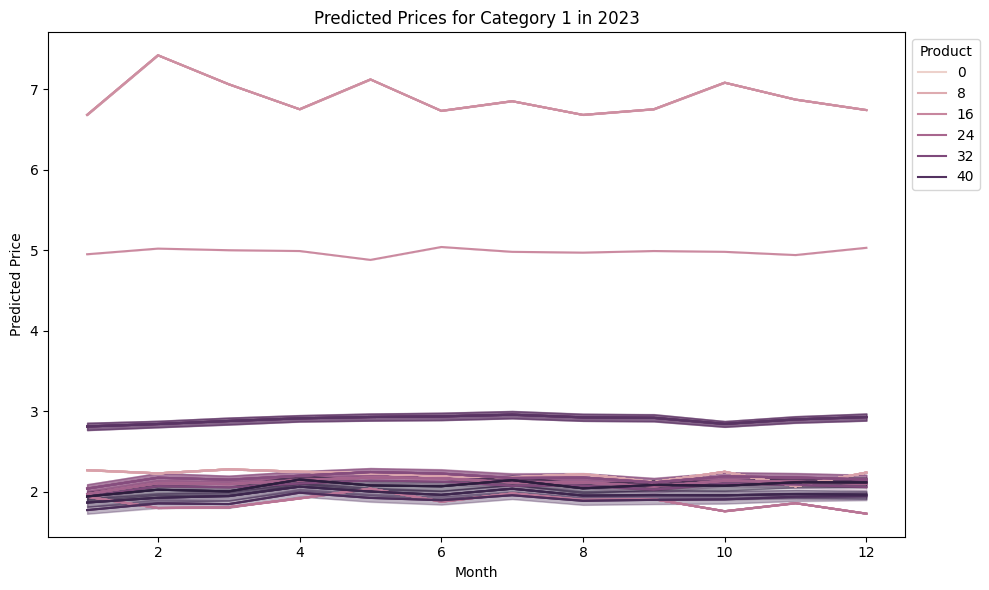

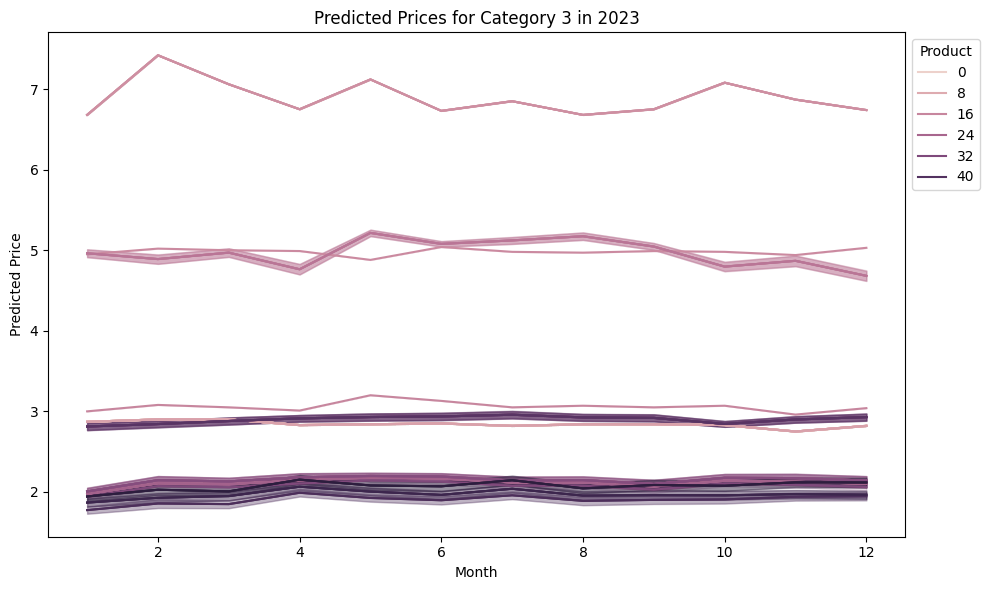

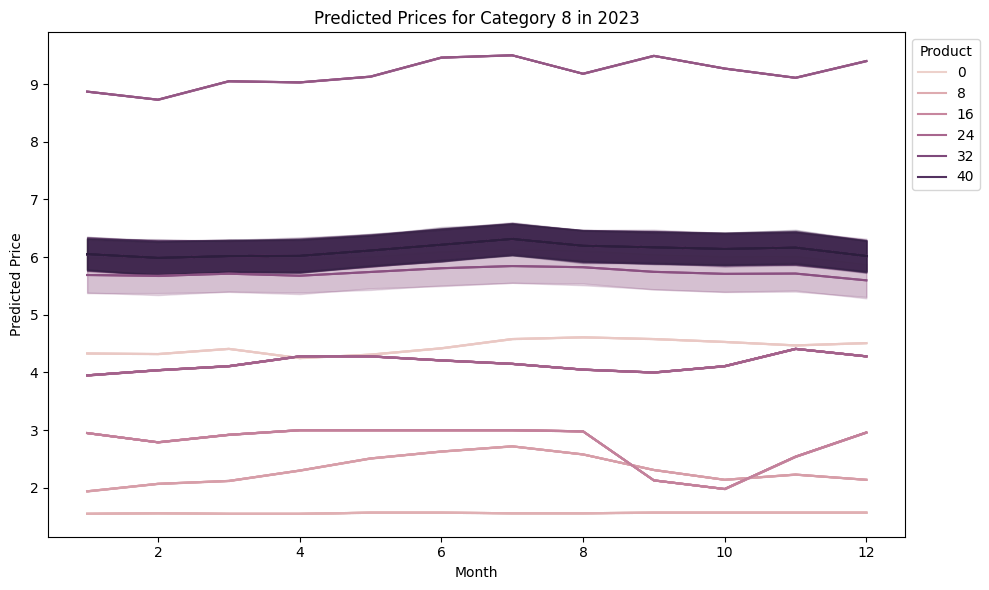

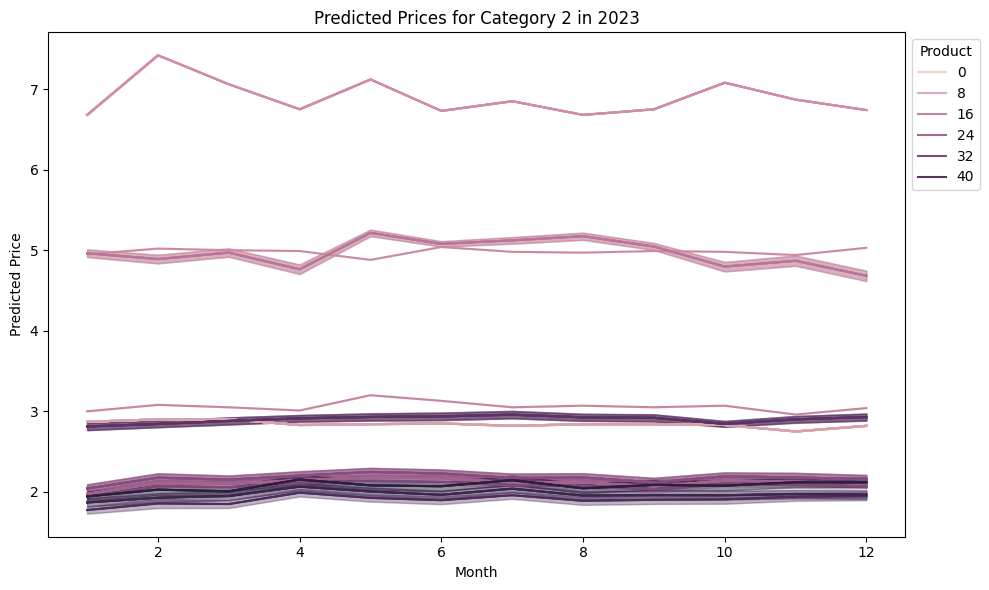

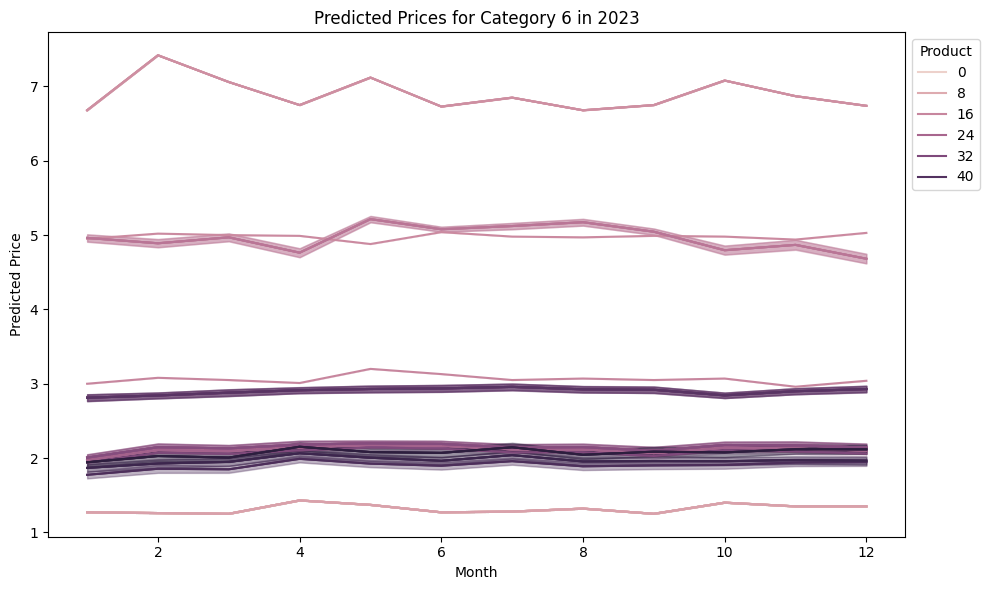

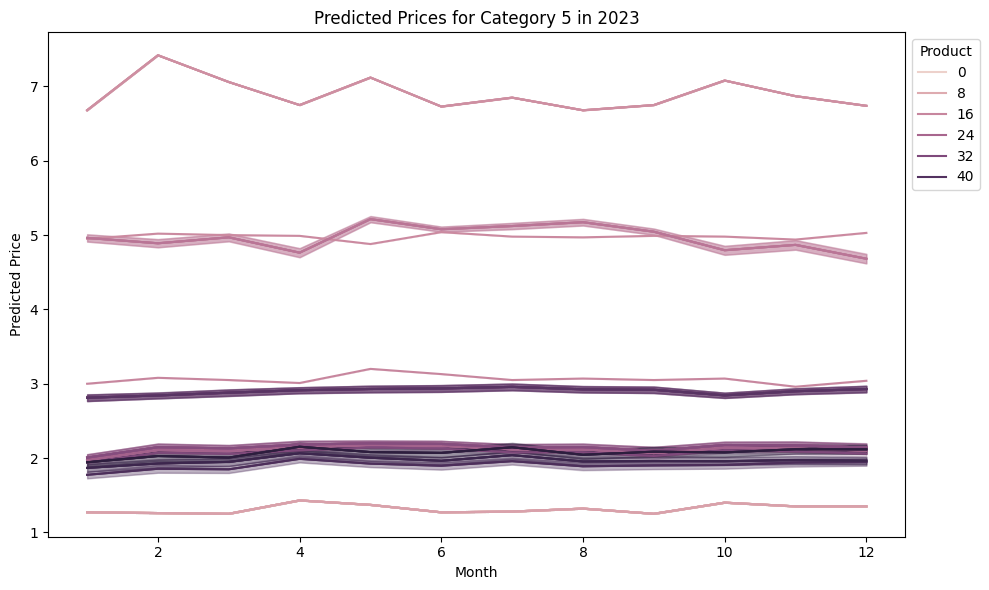

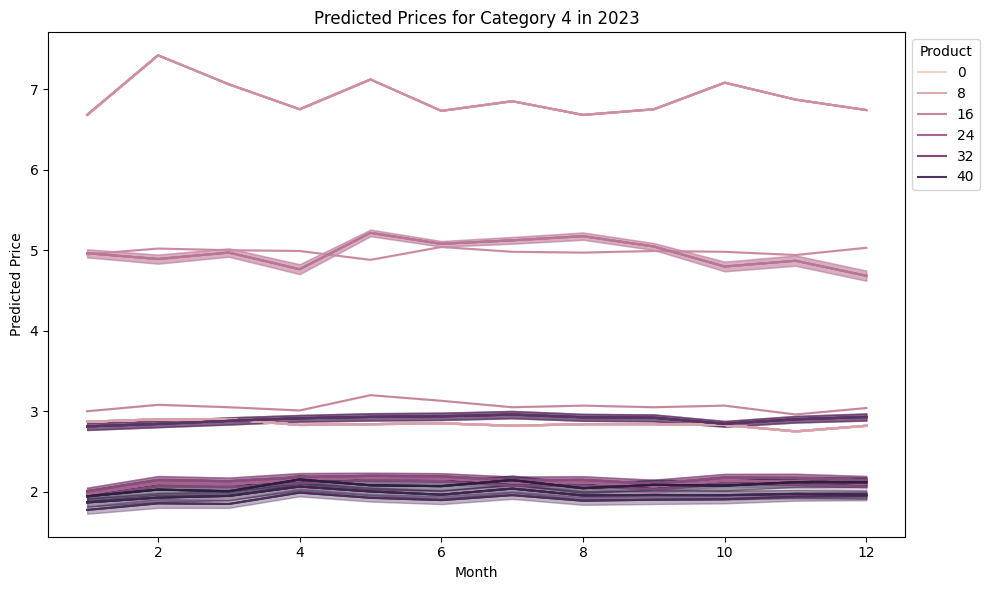

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from datetime import datetime

class ModelPredictor:
    def __init__(self, model, data, features, categories):
        self.model = model
        self.data = data
        self.features = features
        self.categories = categories

    def generate_2023_data(self):
        # Generate feature data for 2023
        df_2023 = pd.DataFrame(product(pd.date_range('2023-01-01', '2023-12-31', freq='D'),
                                       self.data['product_encoded'].unique(),
                                       self.data['unit_quantity'].unique(),
                                       self.data['category_encoded'].unique()),
                               columns=['date', 'product_encoded', 'unit_quantity', 'category_encoded'])

        # Decompose date into year, month, and day
        df_2023['year'] = df_2023['date'].dt.year
        df_2023['month'] = df_2023['date'].dt.month
        df_2023['day'] = df_2023['date'].dt.day

        return df_2023

    def predict_prices(self):
        df_2023 = self.generate_2023_data()
        df_2023 = df_2023[self.features]
        predicted_prices = self.model.predict(df_2023)
        df_2023['predicted_price'] = predicted_prices
        return df_2023

    def plot_predictions(self, predictions):
        for category in self.categories:
            plt.figure(figsize=(10, 6))
            category_data = predictions[predictions['category_encoded'] == category]
            sns.lineplot(data=category_data, x='month', y='predicted_price', hue='product_encoded')
            plt.title(f'Predicted Prices for Category {category} in 2023')
            plt.ylabel('Predicted Price')
            plt.xlabel('Month')
            plt.legend(title='Product', loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
            plt.show()

# Usage
predictor = ModelPredictor(trainer.model, preprocessed_data, features, preprocessed_data['category_encoded'].unique())
predictions_2023 = predictor.predict_prices()
predictor.plot_predictions(predictions_2023)


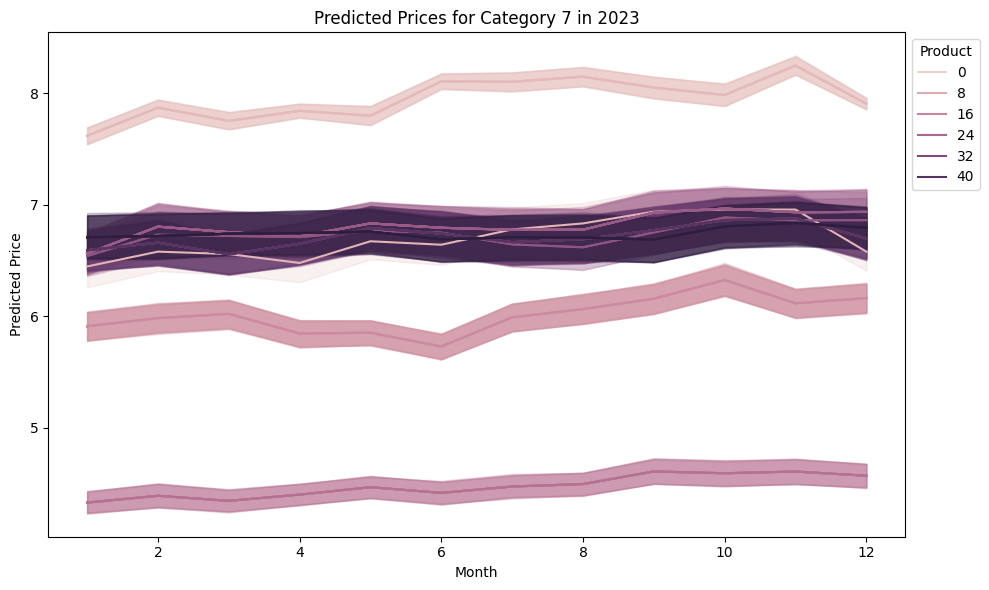

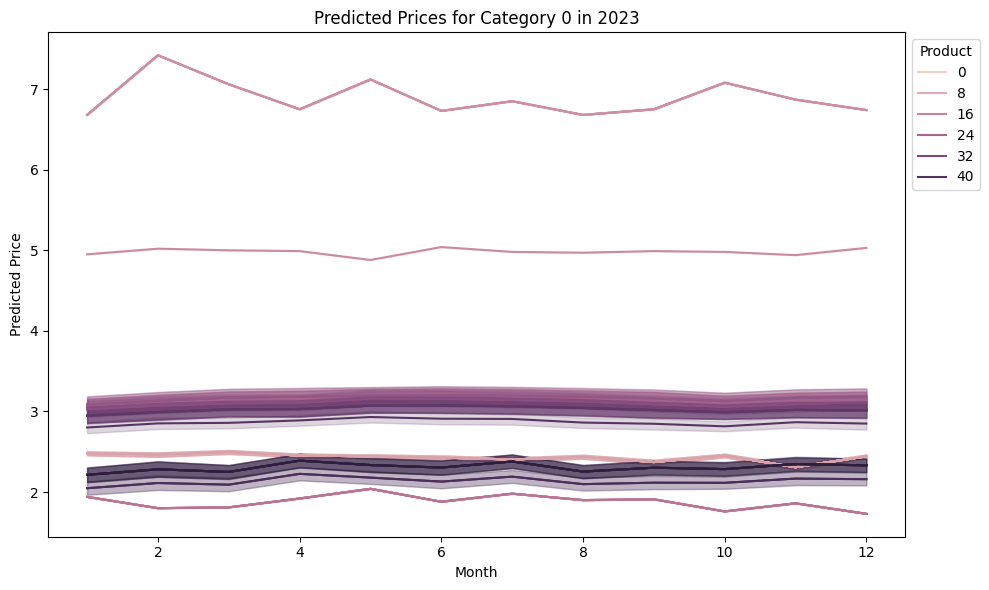

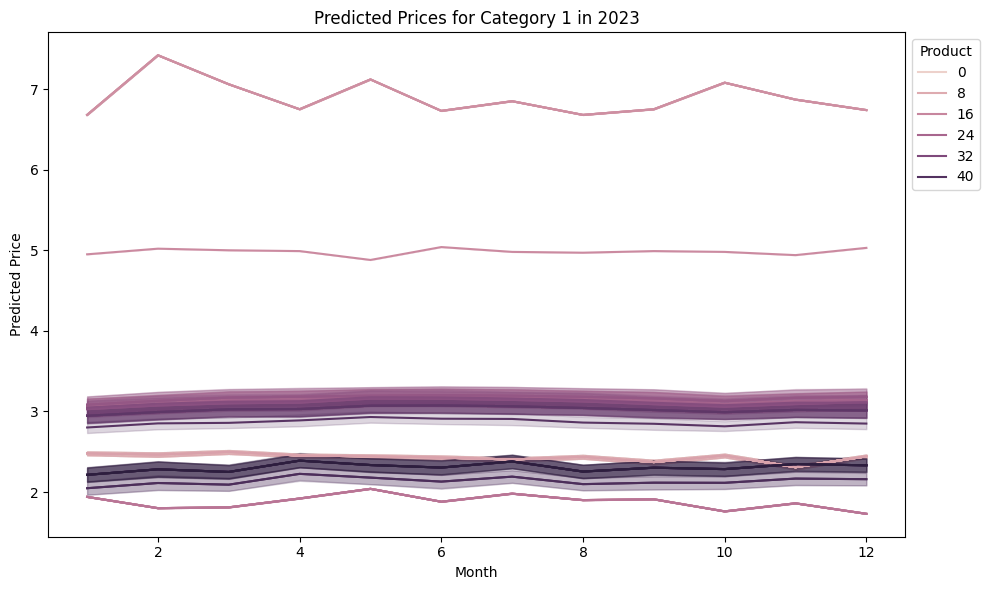

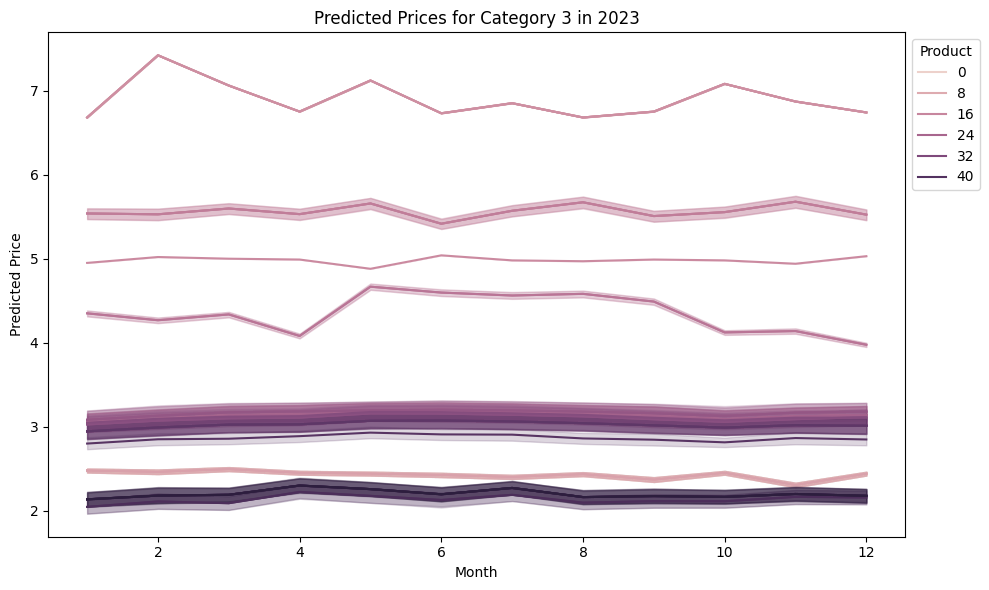

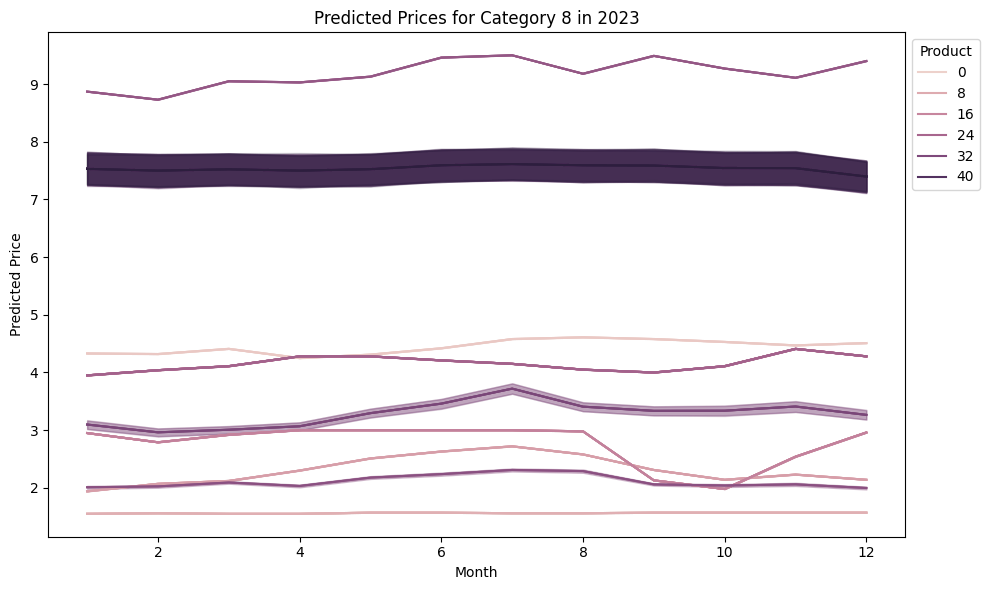

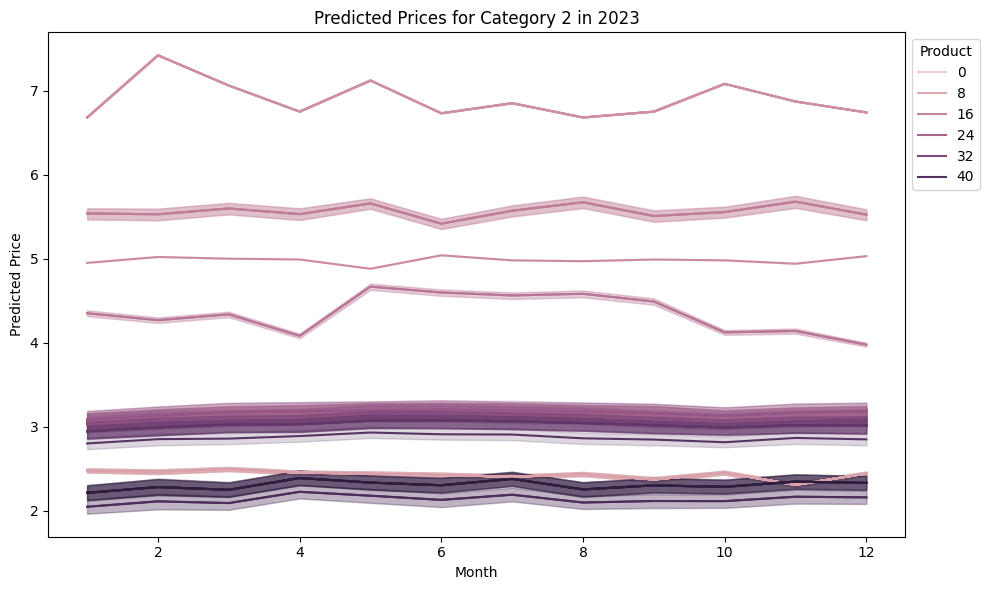

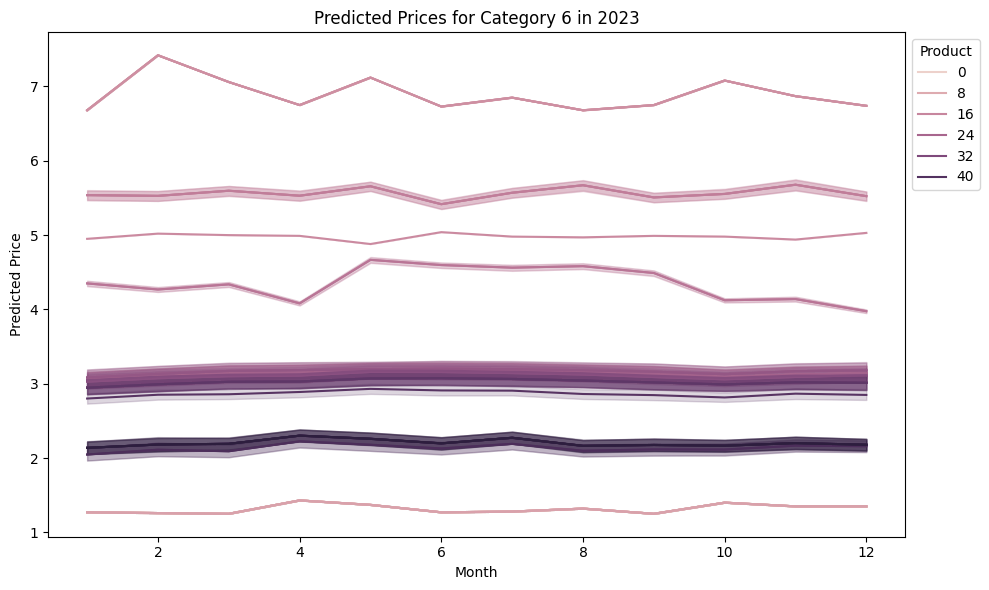

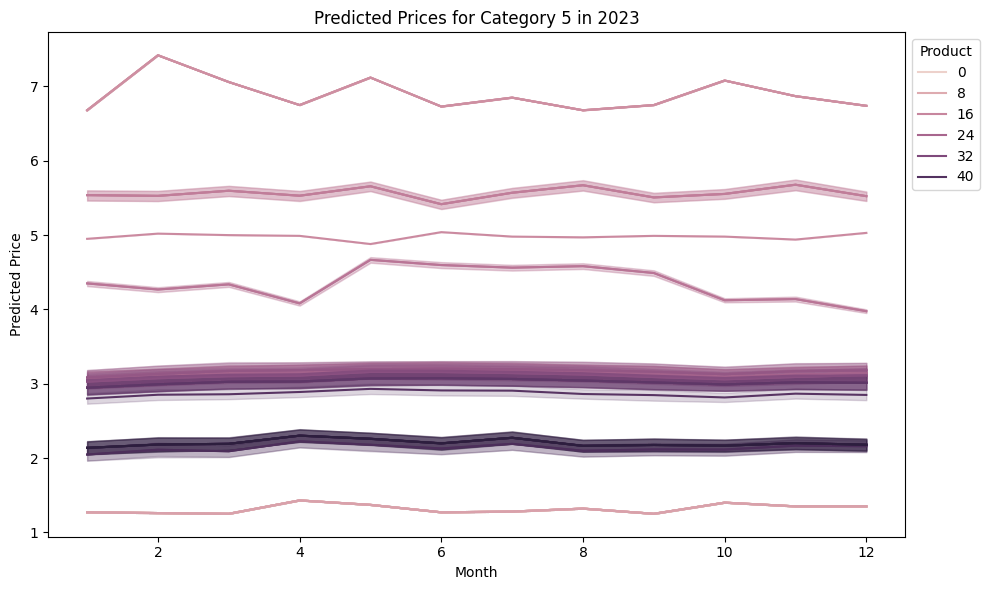

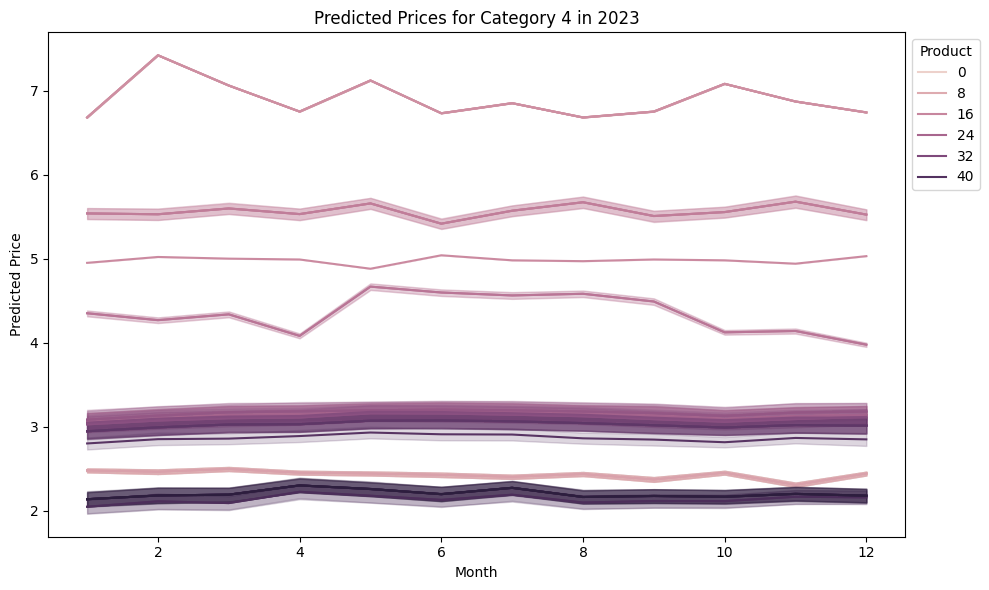

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from datetime import datetime

class ModelPredictor:
    def __init__(self, model, datxa, features, categories):
        self.model = model
        self.data = data
        self.features = features
        self.categories = categories

    def generate_2023_data(self):
        # Generate feature data for 2023
        df_2023 = pd.DataFrame(product(pd.date_range('2023-01-01', '2023-12-31', freq='D'),
                                       self.data['product_encoded'].unique(),
                                       self.data['unit_quantity'].unique(),
                                       self.data['category_encoded'].unique()),
                               columns=['date', 'product_encoded', 'unit_quantity', 'category_encoded'])

        # Decompose date into year, month, and day
        df_2023['year'] = df_2023['date'].dt.year
        df_2023['month'] = df_2023['date'].dt.month
        df_2023['day'] = df_2023['date'].dt.day

        return df_2023

    def predict_prices(self):
        df_2023 = self.generate_2023_data()
        df_2023 = df_2023[self.features]
        predicted_prices = self.model.predict(df_2023)
        df_2023['predicted_price'] = predicted_prices
        return df_2023

    def plot_predictions(self, predictions):
        for category in self.categories:
            plt.figure(figsize=(10, 6))
            category_data = predictions[predictions['category_encoded'] == category]
            sns.lineplot(data=category_data, x='month', y='predicted_price', hue='product_encoded')
            plt.title(f'Predicted Prices for Category {category} in 2023')
            plt.ylabel('Predicted Price')
            plt.xlabel('Month')
            plt.legend(title='Product', loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
            plt.show()

# Usage
predictor = ModelPredictor(trainer.model, preprocessed_data, features, preprocessed_data['category_encoded'].unique())
predictions_2023 = predictor.predict_prices()
predictor.plot_predictions(predictions_2023)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from datetime import datetime

class ModelPredictor:
    def __init__(self, model, data, features, categories):
        self.model = model
        self.data = data
        self.features = features
        self.categories = categories

    def generate_2023_data(self):
        # Generate feature data for 2023
        df_2023 = pd.DataFrame(product(pd.date_range('2023-01-01', '2023-12-31', freq='D'),
                                       self.data['product_encoded'].unique(),
                                       self.data['unit_quantity'].unique(),
                                       self.data['category_encoded'].unique()),
                               columns=['date', 'product_encoded', 'unit_quantity', 'category_encoded'])

        # Decompose date into year, month, and day
        df_2023['year'] = df_2023['date'].dt.year
        df_2023['month'] = df_2023['date'].dt.month
        df_2023['day'] = df_2023['date'].dt.day

        return df_2023

    def predict_prices(self):
        df_2023 = self.generate_2023_data()
        df_2023 = df_2023[self.features]
        predicted_prices = self.model.predict(df_2023)
        df_2023['predicted_price'] = predicted_prices
        return df_2023

    def display_predicted_prices_table(self, predictions):
        # Displaying predicted prices in a table format
        average_prices = predictions.groupby(['category_encoded', 'product_encoded'])['predicted_price'].mean().reset_index()
        print("Average Predicted Prices for Each Product in 2023:")
        display(average_prices)

# Usage
predictor = ModelPredictor(trainer.model, preprocessed_data, features, preprocessed_data['category_encoded'].unique())
predictions_2023 = predictor.predict_prices()
predictor.display_predicted_prices_table(predictions_2023)


Average Predicted Prices for Each Product in 2023:


,category_encoded,product_encoded,predicted_price
0,0,0,2.212082
1,0,1,2.212082
2,0,2,2.212082
3,0,3,2.212082
4,0,4,2.212082
...,...,...,...
427,8,43,6.119137
428,8,44,6.119137
429,8,45,6.119137
430,8,46,6.119137
